# Time series prediction (Part 2)

**NB objectives**
- [ ] Get to use few prediction models
- [ ] Understand what CV is for

**Required librairies**
- [ ] matplotlib
- [ ] numpy
- [ ] pandas
- [ ] seaborn
- [ ] pmdarima

## Prediction models

### ARIMA

#### Theory behind

Le modèle ARMA (AutoRegressive Moving Average) ou ARMA (autorégressifs et moyenne mobile) en français, est un modèle adapté au prédiction sur toute série temporelle dont la valeur $Y$ à l'instant $t$ peut s'expliquer par les valeurs précédentes et les perturbations (bruits) précédentes.

Avant de préciser ce qu'est un jeu de donnée suivant le modèle ARIMA, précisons un jeu de donnée suivant les conditions :  

- **Autoregressif** : le modèle prédit la variable $Y$ à l'instant $t$, notée $Y_t$, à partir des valeurs précédentes de $Y$ selon un modèle de regression linéaire, c'est à dire $Y_{t-1}, Y_{t-2}, ..., Y_0$. On note $p$ le nombre de composantes utilisées pour prédire $Y_t$, avec

> $Y_t = \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + c$, avec $\varepsilon_t$ une perturbation, et c une constante.

- **Moyenne mobile**: un modèle où les données sont le résultat de la moyenne mobile d'ordre $q$. Il est possible d'exprimer la valeur $Y_t$ à l'aide de la perturbation à l'instant $t$ et ses valeurs précédentes :

> $Y_t = \mu + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t-q}$, avec $\mu$ une constante.

Tout jeu de données ARIMA est la combinaison des conditions *AR* et *MA*, c'est à dire qu'il est autoregressif et son bruit suit une moyenne mobile. Soit :

> $Y_t =  c + \sum_{i=1}^p \varphi_i\,Y_{t-i} + \varepsilon_t + \sum_{1}^{q}\theta_q\varepsilon_{t_q}$

ou :

> $Y_t - \sum_{i=1}^p \varphi_i Y_{t-i} = \varepsilon_t + \sum_{i=1}^q \theta_i \varepsilon_{t-i}$ avec $\varepsilon_t$ l'erreur du modèle autoregressif à l'instant $t$.

Le modèle est optimisé à l'aide de la méthode des moindres carrées.


Un modèle ARMA est adapté à des jeux de données stationnaires, c'est à dire avec une moyenne et un écart type fixe au cours du temps. Il est rare que l'on observe de telles données. De nombreux jeux de données de séries temporelles présentent des tendances sur la moyenne ou encore des saisonnalités. Pour cela, il convient de stationnariser dans un premier temps le problème. On parle **d'intégration**. Un modèle **ARIMA** est dit :

- **intégré** : lorsqu'on peut corriger le jeu de donnée en réalisant le modèle sur $Y'_t = Y_t - Y_{t-1}$ pour une correction d'ordre 1 (d=1) ou encore $Y''_t = Y_t - Y_{t-1} - Y_{t-2}$ pour une correction d'ordre 2 (d=2), etc...  On note $d$ l'ordre de *correction par intégration* permet de supprimer les tendances polynomiales d'ordre $d$, avec:
    
> $Ycorr_t = Y_t - \sum_{1}^{d} Y_{t-d}$


Les modèles ARIMA sont souvent notés : ARIMA(p, d, q), soit **ARIMA(2, 1, 1)** signifie :
- un modèle autoregressif d'ordre 2,
- sur des données intégrées 1 fois,
- et avec une moyenne mobile d'ordre 1.

#### Bit of practice

##### Discover and prepare data

In [1]:
#Import required packages (to be implemented if required)
import pmdarima as pm 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt

from pmdarima.datasets import load_airpassengers


In [2]:
START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

#there's no datetimeindex from the bundled dataset. So let's add one.
airline.index= pd.date_range(START_DATE, periods=len(airline), freq='MS')

In [3]:
airline

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Length: 144, dtype: float64

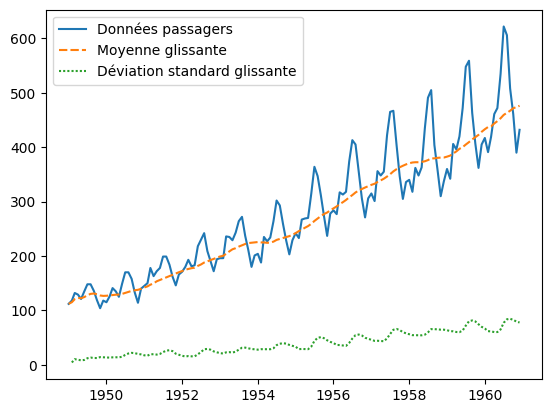

In [4]:
# Combined Plot to assess: 
# - "Données passagers", 
# - "Moyenne glissante" et 
# - "Deviation standard glissante"
passenger_data = airline.values
rolling_mean = airline.rolling("365D").mean()
rolling_sd =  airline.rolling("365D").std()
df = pd.DataFrame(
    {
        'Données passagers':passenger_data,
        'Moyenne glissante ':rolling_mean, 
        'Déviation standard glissante':rolling_sd
    }
)
sns.lineplot(df)

plt.show()

**Conclusions:**
- Is this time serie stationary or not? <font color="brown"> No </font>
- What is its tendancy? <font color="brown"> Increasing mean and std + seasonality => need cleaning </font>
- What about heteroskedasticity? <font color="brown"> Yes => need cleaning </font>

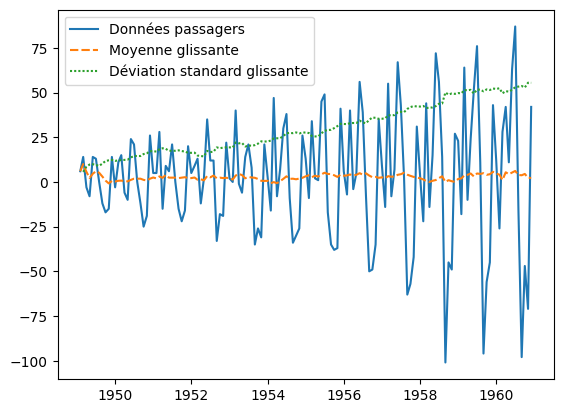

In [5]:
# Plot2: same infos as previously but with date on x axis and Y(t)-Y(t-1) on y axis
# Use airline.diff().values
airline_transposed = airline.diff(1)
passenger_data = airline_transposed.values
rolling_mean = airline_transposed.rolling("365D").mean()
rolling_sd =  airline_transposed.rolling("365D").std()
df = pd.DataFrame(
    {
        'Données passagers':passenger_data,
        'Moyenne glissante ':rolling_mean, 
        'Déviation standard glissante':rolling_sd
    }
)
sns.lineplot(df)

plt.show()

**Observations:**
 - What about the stationarity? <font color="brown"> Now OK </font>
 - What about the variance and how to deal with it? <font color="brown"> Increasing with time => get log values </font>

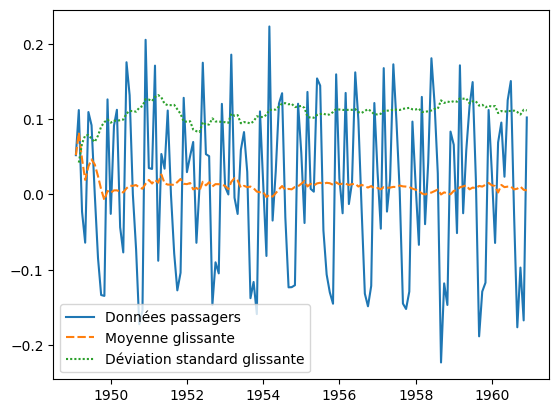

In [6]:
# Plot 2 with modification defined in your previous conclusion

airline_transposed = np.log(airline).diff(1)
passenger_data = airline_transposed.values
rolling_mean = airline_transposed.rolling("365D").mean()
rolling_sd =  airline_transposed.rolling("365D").std()
df = pd.DataFrame(
    {
        'Données passagers':passenger_data,
        'Moyenne glissante ':rolling_mean, 
        'Déviation standard glissante':rolling_sd
    }
)
sns.lineplot(df)

plt.show()


**Observations:**
 - What about mean and deviation? Stationarity? <font color="brown"> mean and std seems constant over time => dataset ok for arima </font>
 
<span style="color:green">Then, it should be possible to apply ARIMA on these transformed data, with order 1 integration: ARIMA(p,1,q)</span>

##### Train/Test split challenges

In [7]:
# Explain why train/test split can be a challenge for time series


Split into train and test have to keep the trend/seasonality of original dataset

the window taken for splitting reflect the max length of the pattern to see

the prediction we want to perform is on future data so test set is ALWAYS after train set

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*UMNyyj5Cqd8hOU2TVIHIzw.png">

In [8]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [9]:
# Hold back the last twelve months as a TEST set
train, test = ts_train_test_split(airline / airline.index.days_in_month, '1959-01-01')

#ou on utilise from sklearn.model_selection import TimeSeriesSplit
# tss = TimeSeriesSplit(n_splits = 3)

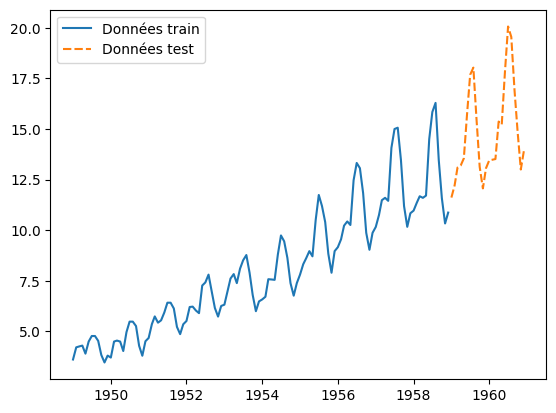

In [10]:
# Plot train and test sets
# test

# airline_transposed = np.log(airline).diff(1)
# passenger_data = airline_transposed.values
# rolling_mean = airline_transposed.rolling("365D").mean()
# rolling_sd =  airline_transposed.rolling("365D").std()
df = pd.DataFrame(
    {
        'Données train':train,
        'Données test ':test, 
        # 'Déviation standard glissante':rolling_sd
    }
)
sns.lineplot(df)

plt.show()


In [11]:
# Do not forget to change your data (log)
train_adj_log = np.log(train)

Afin de valider les paramètres $p$ (*AR*) et $q$ (*MA*) du modèle ARIMA, l'on peut calculer l'auto-corrélation des données temporelles.
- Pour déterminer $p$ nous utiliserons l'autocorrelation des données par une donnée passée avec un décalage temporel (appelé *lag* en anglais). On utilisera pour cela la PACF (*Partial Auto Correlation Function*). La fonction PACF cherche à déterminer la correlation entre les données $Y_t$ et $Y_{t-i}$. La valeur de $p$ est déterminée par $PACF_i \approx 0$  
- pour déterminer $q$, on utilisera l'ACF (*Auto Correlation Function*). La fonction ACF calcule la correlation entre la série temporelle et elle-même avec un décalage temporel. Soit calculer la correlation de $Y_(t, t-1, ...)$ avec $Y_(t-i, t-i-1, ...)$.

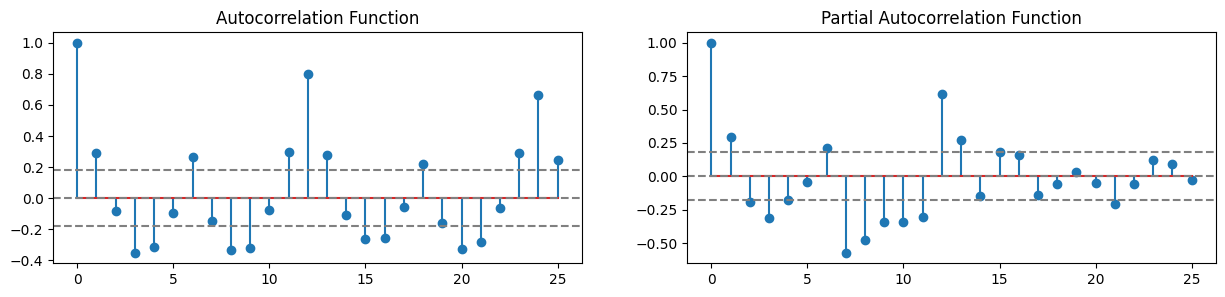

In [12]:
#ACF & PACF plots
from pmdarima.utils import acf, pacf

n_sample = len(train)
lag_acf = acf(np.log(train).diff().dropna(), nlags=25)
lag_pacf = pacf(np.log(train).diff().dropna(), nlags=25)

pct_95 = 1.96/np.sqrt(n_sample)

plt.figure(figsize=(15, 3))
#Plot ACF:
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray')
plt.axhline(y=pct_95, linestyle='--', color='gray')
# plt.axvline(x=q, color='black', linestyle='--', label=f'q={q}')
# plt.legend()
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray') # represent 95 % of a gaussian data
plt.axhline(y=pct_95, linestyle='--', color='gray') # represente 95 % of a gaussian data
# plt.axvline(x=p, color='black', linestyle='--', label=f'p={p}')
plt.title('Partial Autocorrelation Function')
# plt.legend()
plt.show()

**Observations**
- What can you tell about the correlation for ACF and PACF?  
<font color="brown"> both : corr=1 at the beggining (normal) then decreases.  
ACF : corr increases every 12 month = annual seasonality.  
PACF :  similar trend, positive and negative correlations > significativity = there is an autoregressive term in data.  
Re-check ACF : the autoregressive term seems to be 12 = 12 months.  </font>  
- Can you explain what you observe on this data (e.g. reasons for observed changes)?  
<font color="brown"> passengers from the same country/region take flights at similar period of the year because of vacations/events/etc which occur every year at the same period (like christmas)</font>

Ressource for PACF/ACF interpretation : 

https://support.minitab.com/fr-fr/minitab/20/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

<span style="color:red">
Even this model presents a seasonality, try modeling as ARIMA(1, 1, 1)
    </span>

<font color="brown"> Résultat :  
- la composante d'autorégression (p) n'a pas été retirée car sur le corrélogramme on a encore une corrélation significative autre que 1 donc p=1 ne semble pas approprié pour nos données
- l'homoscédasticité semble respectée d'après la dispersion des résidus standardisés donc le terme d'intégration (d=1) semble approprié 
- la composante de moyenne mobile (q) ne semble pas adéquate car l'histogramme/density plot n'est pas symétrique/ne suiventpas une loi normale, donc q=1 ne semble pas OK</font>

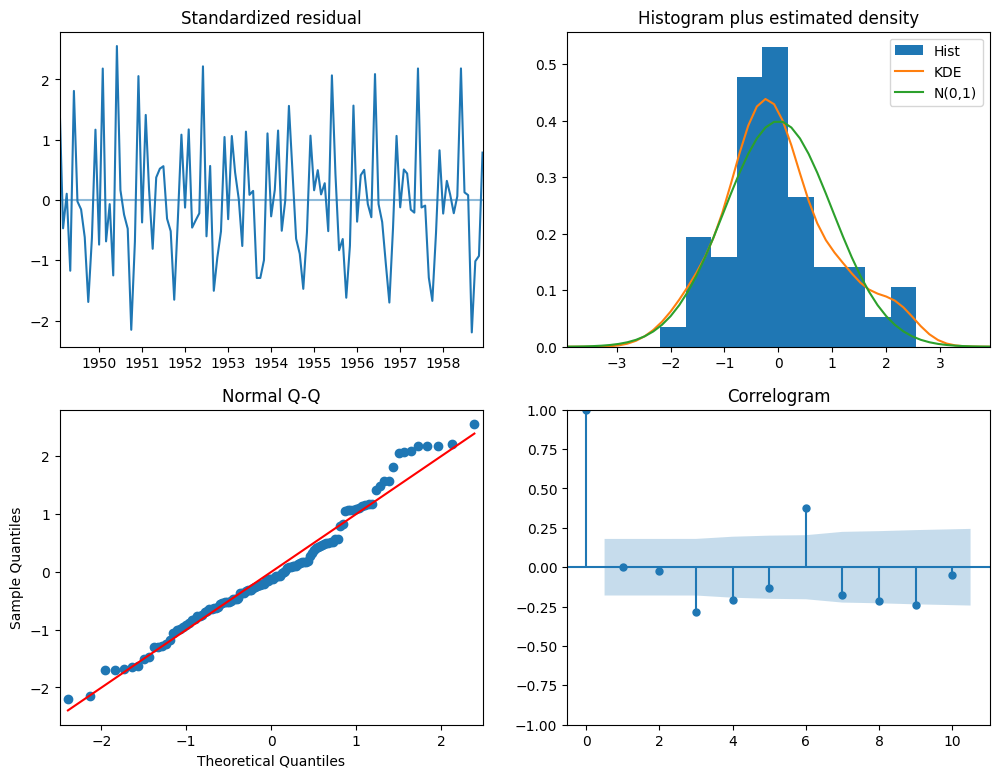

In [15]:
from pmdarima.arima import ARIMA
#https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA

model = ARIMA(order=(1, 1, 1), suppress_warnings = True) # seasonal_order=(0, 1, 1, 12)
model.fit(np.log(train))
model.plot_diagnostics(figsize=(12,9))
plt.show()

<font color="brown"> Si on rajoute un terme de saisonnalité supplémentaire dans le modèle avec P, D, Q, m = 0, 1, 1, 12 :  
- la composante d'autorégression (p) a été retirée car sur le corrélogramme on n'a plus de corrélation significative autre que 1 
- l'homoscédasticité semble respectée d'après la dispersion des résidus standardisés 
- la composante de moyenne mobile ne semble pas adéquate car l'histogramme/density plot n'est pas symétrique/ne suiventpas une loi normale</font>

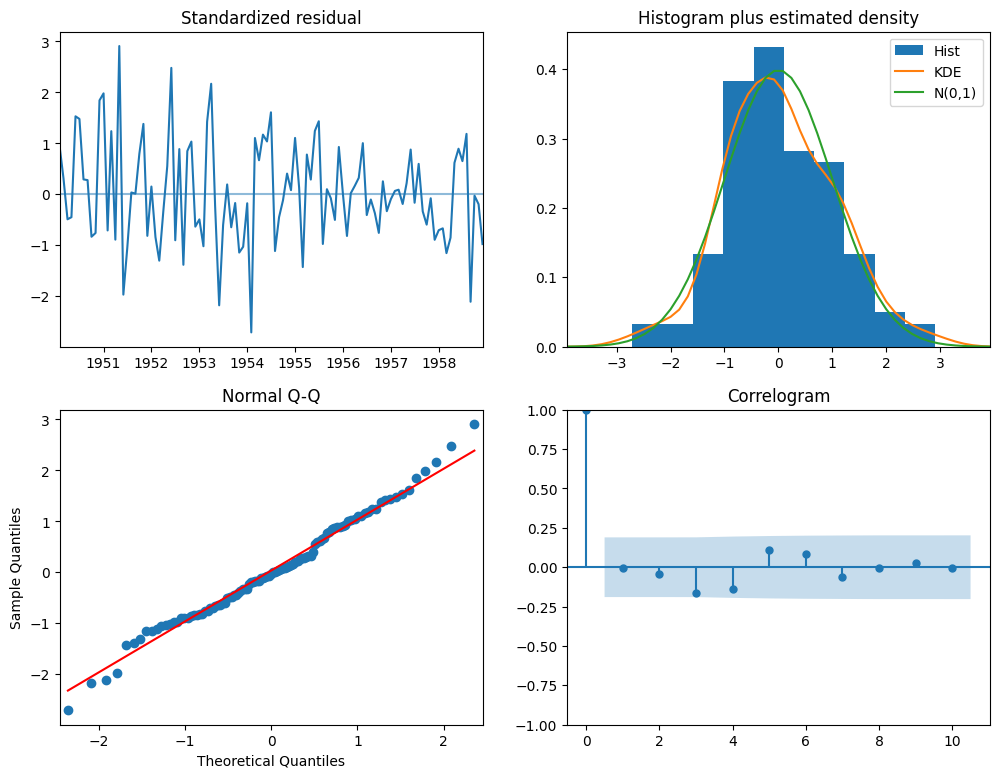

In [16]:
from pmdarima.arima import ARIMA
#https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA

model = ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), suppress_warnings = True) #à l'intérieur des saisons de pdq, on rajoute un terme supplémentaire de saison PDQ avec un nombre de période m = 12
model.fit(np.log(train))
model.plot_diagnostics(figsize=(12,9))
plt.show()

<font color="brown"> Si modélise avec p,d,q = 12,1,12 :  
- la composante d'autorégression (p=12) est OK car sur le corrélogramme on n'a plus de corrélation significative autre que 1 
- l'homoscédasticité semble respectée d'après la dispersion des résidus standardisés donc composante d'intégration d=1 semble OK
- la composante de moyenne mobile (q=12) semble adéquate car l'histogramme/density plot est pas symétrique/ suit une loi normale</font>

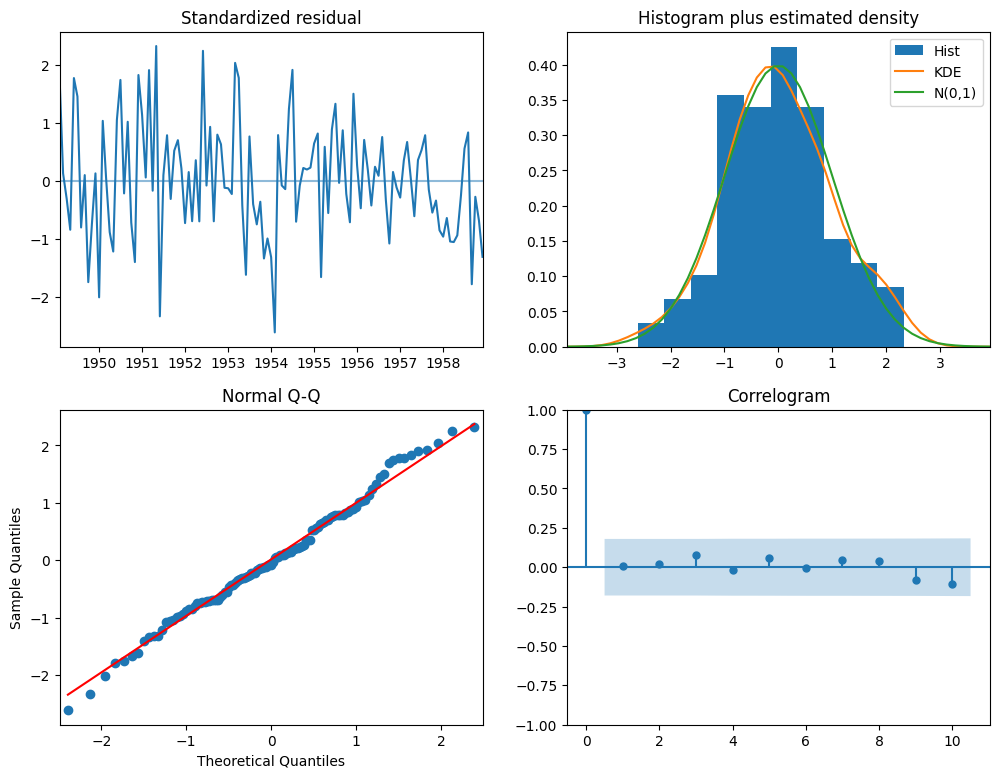

In [26]:
from pmdarima.arima import ARIMA
#https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA

model = ARIMA(order=(12, 1, 12), suppress_warnings = True) # seasonal_order=(0, 1, 1, 12)
model.fit(np.log(train))
model.plot_diagnostics(figsize=(12,9))
plt.show()

In [27]:
# Describe what you see on previous graphes
# Why diagnostics functions are usefull?

<font color="brown"> description ci-dessus  
les fonction de diagnostique permettent d'évaluer les paramètres p,d,q du modèle ARIMA 
</font>


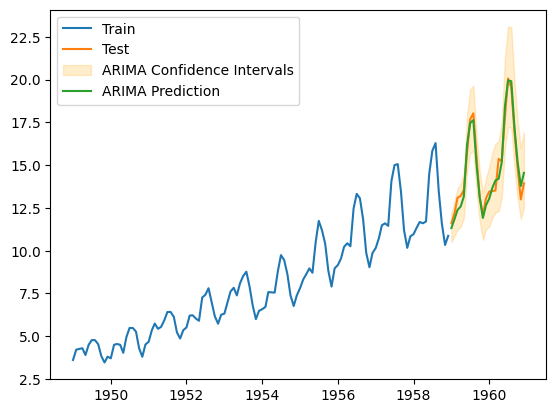

In [28]:
# Use np.exp(prediction) to change log data back to "Normal"
plt.plot(train, label='Train')
plt.plot(test, label='Test')
y_pred, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
plt.fill_between(y_pred.index,
                 *np.exp(conf_int).T,
                 alpha=0.2, color='orange',
                 label="ARIMA Confidence Intervals")
plt.plot(np.exp(y_pred), label='ARIMA Prediction')
plt.legend()
plt.show()

Now, find the error!

<font color="brown">
le RMSE/mean permet d'avoir la rmse en % de la moyenne et d'avoir une idée de l'ordre de grandeur de la rmse
</font>

In [33]:
from sklearn.metrics import mean_squared_error
#Calculate RMSE and RMSE/mean(test)
rmse = mean_squared_error(y_true=test, y_pred=np.exp(y_pred))**(1/2)
rmse_scaled = rmse/np.mean(test)
print(f"Test RMSE : {rmse}, RMSE/mean : {rmse_scaled}, test mean : {np.mean(test)}, test std : {np.std(test)}")
#Pour pallier à cet effet, il est plus intéressant de normaliser le RMSE pour que cet indicateur soit exprimé comme 
#un pourcentage de la valeur moyenne des observations. Cela peut être utilisé pour donner plus de sens à l’indicateur.

Test RMSE : 0.48354486497385085, RMSE/mean : 0.03259505971432802, test mean : 14.834912689584547, test std : 2.334765738156696


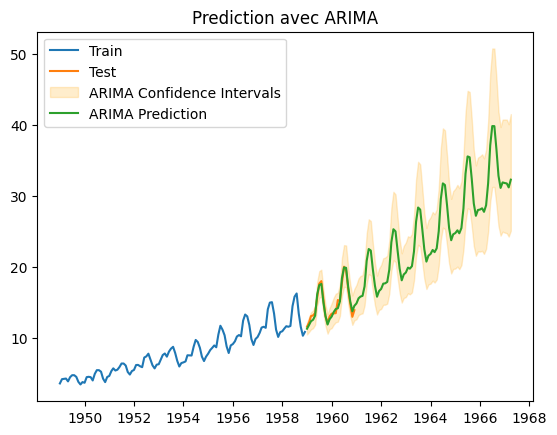

In [34]:
# données connues
plt.plot(train, label='Train')
plt.plot(test, label='Test')

# prediction
y_pred, conf_int = model.predict(n_periods=100, return_conf_int=True)
plt.fill_between(y_pred.index,
                 *np.exp(conf_int).T,
                 alpha=0.2, color='orange',
                 label="ARIMA Confidence Intervals")
plt.plot(np.exp(y_pred), label='ARIMA Prediction')

plt.title('Prediction avec ARIMA')
plt.legend()
plt.show()

**Conclusions**
- Yours? <font color="brown"> modélisation semble OK </font>
- What do you think about the error? <font color="brown"> augmente au cours du temps => normal c'est difficile d'avoir des prédictions précises quand on s'éloigne ? Et normal car dataset petit ?</font>

##### CV with ARIMA

In [35]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

In [36]:
#manually create the arima model
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

In [38]:
#https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.model_selection.RollingForecastCV.html#pmdarima.model_selection.RollingForecastCV
HORIZON = 1
cv = RollingForecastCV(h=HORIZON, step=10) # initially uses 1/3 of the training size

In [43]:
#for cv need all of the training data joined together.
airline_adj = airline / airline.index.days_in_month
# airline_adj = np.log(airline_adj) # transform
train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model

cv_results = cross_val_score(model, train_log, cv=cv, scoring='mean_absolute_error')
print(cv_results, f'mean : {np.mean(np.round(cv_results, 2))}')

[0.02555635 0.01839385 0.0344751  0.02801097 0.01876992 0.0084053
 0.02079696 0.01997573 0.02862277] mean : 0.02333333333333333


In [40]:
#how many splits did we get?
len(cv_results)

9

In [51]:
def split_parameters_search_cv(horizon_list, step_list, model_in, train_set):

    for step in step_list:
        print(f"Step : {step}")
        for horizon in horizon_list:
            print(f'Horizon : {horizon}')
            cv = RollingForecastCV(h=horizon, step=step) 
            cv_results = cross_val_score(model_in, train_set, cv=cv, scoring='mean_absolute_error')
            mean_cv=np.mean(cv_results)
            print(f"cv_res : {cv_results}, mean_res : {mean_cv}")


model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)
horizon = [1]
step_list = [1,5,10]

airline_adj = airline / airline.index.days_in_month
train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model

# split_parameters_search_cv(horizon, step_list, model, train_log)
print("Step : 30, Horizon : 1")
cv = RollingForecastCV(h=1, step=30) 
cv_results = cross_val_score(model, train_log, cv=cv, scoring='mean_absolute_error')
mean_cv=np.mean(cv_results)
print(f"cv_res : {cv_results}, mean_res : {mean_cv}")

print("Step : 20, Horizon : 1")
cv = RollingForecastCV(h=1, step=20) 
cv_results = cross_val_score(model, train_log, cv=cv, scoring='mean_absolute_error')
mean_cv=np.mean(cv_results)
print(f"cv_res : {cv_results}, mean_res : {mean_cv}")

print("Step : 10, Horizon : 1")
cv = RollingForecastCV(h=1, step=10) 
cv_results = cross_val_score(model, train_log, cv=cv, scoring='mean_absolute_error')
mean_cv=np.mean(cv_results)
print(f"cv_res : {cv_results}, mean_res : {mean_cv}")

print("Step : 10, Horizon : 2")
cv = RollingForecastCV(h=2, step=10) 
cv_results = cross_val_score(model, train_log, cv=cv, scoring='mean_absolute_error')
mean_cv=np.mean(cv_results)
print(f"cv_res : {cv_results}, mean_res : {mean_cv}")

print("Step : 10, Horizon : 3")
cv = RollingForecastCV(h=3, step=10) 
cv_results = cross_val_score(model, train_log, cv=cv, scoring='mean_absolute_error')
mean_cv=np.mean(cv_results)
print(f"cv_res : {cv_results}, mean_res : {mean_cv}")

Step : 30, Horizon : 1
cv_res : [0.03942447 0.0503431  0.01235033], mean_res : 0.034039299295320014
Step : 20, Horizon : 1
cv_res : [0.03942447 0.02941773 0.00644033 0.01235033 0.02339601], mean_res : 0.02220577391514391
Step : 10, Horizon : 1
cv_res : [0.03942447 0.03019449 0.02941773 0.0503431  0.00644033 0.00544532
 0.01235033 0.00650058 0.02339601], mean_res : 0.022612485363597883
Step : 10, Horizon : 2
cv_res : [0.02555635 0.01839385 0.0344751  0.02801097 0.01876992 0.0084053
 0.02079696 0.01997573 0.02862277], mean_res : 0.022556328311148843
Step : 10, Horizon : 3
cv_res : [0.03143176 0.02861771 0.04916612 0.02117533 0.01867739 0.00935767
 0.02244628 0.03521985 0.01994969], mean_res : 0.02622686682715375


In [52]:

144/3

48.0

**TASK**
* go back and try different step values in the RollingForecastCV
* What changes?  
<font color="brown"> 
1) quand on augmente 'step' on augmente de la valeur 'step' la taille du dataset => si on augmnte de 10 on aura + de training que si on augmente par 20 jusqu'au max des données, si on augmente 1 par 1 ça prend bcp trop de temps. plus l'augmentation est grande, moins on aura de splits (logique).   
2) quand on augmente 'horizon' de 1 à 2 on augmente le décalage (l'espace en terme de nb de données qu'on passe) entre le train et le test : plus cet espace est grand, plus la mae augmente = prédiction moins précise</font>
* In each case what size is the data is the model training on?  


<font color="brown">  
Exemple pour <Step : 30, Horizon : 1>  
initialement : 144/3=48 (train), 1 (test)  
deuxième itération : 48+30=78 (train), 1 (test)  
troisième itération : 48+30+30=108 (train), 1 (test)  

Exemple pour <Step : 30, Horizon : 2>    
initialement : 144/3=48 (train), 2 (test)  
deuxième itération : 48+30=78 (train), 2 (test)  
troisième itération : 48+30+30=108 (train), 2 (test)  
</font>


##### Dealing now with seasonality: SARIMA

As previously seen, ARIMA model is for stationary data. It may even works for data presenting seasonality. However, seasonality is not clearly expressed. If data shows seasonality less simple as for the airport's data, calculation complexity and time can explode.

*eg:Data compiling sun activity with a seasonality of 12 +/-1 year would require a minimum of p=12*12 to comprehend seasonality of the problem.*

<span style="color: blue">Here comes SARIMA: Seasonal-ARIMA!</span>

In [ ]:
# What are these parameters: (p,d,q) and (P,D,Q) ?

<font color="brown"> 

p : autoregression coefficient, le bon p permet d'expliquer la valeur de Y avec les p termes Yt-i    
d : integration coefficient, le bon d permet de supprimer la tendance de la série pour qu'elle deviennet stationnaire  
q : regression error / moving average, le bon q permet d'expliquer la valeur à t par une combinaison d'erreurs aléatoires (=bruit blanc)  

P, D, Q  : mêmes coefficients que précédemment mais dans la saison donnée de période m ou s (selon les sources, m dans pdmarima)  

</font>

In [53]:
# Make sure data form

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def moving_std(a, n=3) :
    j = len(a) - n
    mov_std = np.array([np.std(a[k:k+n]) for k in range(j)])
    return mov_std

In [55]:
train_log

1949-01-01    1.284512
1949-02-01    1.438480
1949-03-01    1.448815
1949-04-01    1.458615
1949-05-01    1.361803
                ...   
1959-08-01    2.892162
1959-09-01    2.736530
1959-10-01    2.574826
1959-11-01    2.490447
1959-12-01    2.569900
Freq: MS, Length: 132, dtype: float64

/home/alexandra.lamotte@Digital-Grenoble.local/miniconda3/envs/ML6/lib/python3.9/site-packages/pmdarima/arima/seasonality.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  detrend = _decomposer_helper(x[sma_xs], trend)


<Axes: >

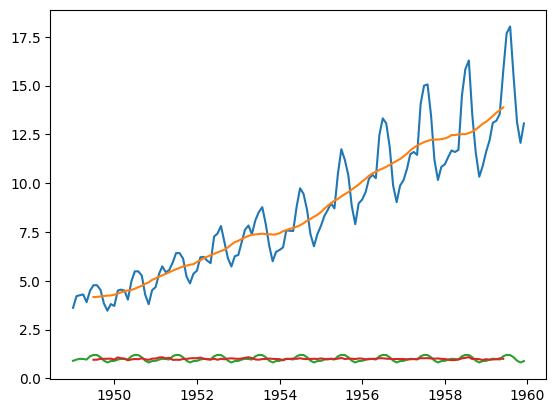

In [90]:
from pmdarima.arima import decompose
from pmdarima.utils import decomposed_plot

# Plot data, trend, seasonal and random infos one by one using arima.decompose
(a,b,c,d) = decompose(train, type_='multiplicative', m=12) #multiplicative car incresing trend
a #data set 
b #trend component
c #seasonal component
d #random component

# decomposition_train = decompose(train, type_='multiplicative', m=12) 
# figure_kwargs = {'figsize': (6, 6)} 
# decomposed_plot(decomposition_train, figure_kwargs=figure_kwargs,
#                              show=True)


# decomposition = decompose(airline, type_='multiplicative', m=12) 
# figure_kwargs = {'figsize': (6, 6)} 
# decomposed_plot(decomposition, figure_kwargs=figure_kwargs,
#                              show=True)
fig, axs = plt.subplots(nrows=4)
sns.lineplot(a)
sns.lineplot(x= a.index.values, y=b)
sns.lineplot(x= a.index.values, y=c)
sns.lineplot(d)


In [ ]:
seasonal_data = decomposed.seasonal + decomposed.trend
seasonal_data = seasonal_data[~np.isnan(seasonal_data)]

plt.plot(np.diff(seasonal_data, 12), label='Seasonal data, cycle 12')
plt.plot(moving_average(seasonal_data, n=12), label='moving avg')
plt.plot(moving_std(seasonal_data, n=12), label='moving std')
plt.title('Seasonal data')
plt.legend()
plt.show()

non_seasonal_data = decomposed.random[~np.isnan(decomposed.random)]
plt.plot(non_seasonal_data, label='Intra seasonal data')
plt.plot(moving_average(non_seasonal_data, n=12), label='moving avg')
plt.plot(moving_std(non_seasonal_data, n=12), label='moving std')
plt.title('Intra seasonal data')
plt.legend()
plt.show()

**Observations**
- What can you conclude about stationarity of seasonal data? Can you then define D and freq?
- Does intra-seasonal data show specific seasonality? What is d (2, 1 or 0)?

In [ ]:
# Quote statistical tests to define stationarity

In [ ]:
freq = 12
ocsb_diffs = nsdiffs(
    train,
    test='ocsb',
    m=12, # time serie frequency
    max_D=12 # max D for seasonality
)
ch_diffs = nsdiffs(train, test='ch', m=freq, max_D=12)
n_diffs = max(ch_diffs, ocsb_diffs)
print(f'Here seasonality for supposed frequency of {freq} is {n_diffs=}')

In [ ]:
#ACF & PACF plots
from pmdarima.utils import acf, pacf

x = np.diff(seasonal_data)

n_sample = len(x)
lag_acf = acf(x, nlags=38)
lag_pacf = pacf(x, nlags=38)

pct_95 = 1.96/np.sqrt(n_sample)

plt.figure(figsize=(15, 3))
#Plot ACF:
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray')
plt.axhline(y=pct_95, linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-pct_95, linestyle='--', color='gray') 
plt.axhline(y=pct_95, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

In [ ]:
#Define q and p

In [ ]:
from pmdarima.arima import ARIMA

model = ARIMA(
    order=(8, 0, 4),
    seasonal_order=(0, 1, 1, 12), # 12 for monthly data
    suppress_warnings = True)
model.fit(np.log(train))
model.plot_diagnostics(figsize=(12,9));

In [ ]:
# données connues
plt.plot(train, label='Train')
plt.plot(test, label='Test')

# prediction
y_pred, conf_int = model.predict(n_periods=100, return_conf_int=True)
plt.fill_between(y_pred.index,
                 *np.exp(conf_int).T,
                 alpha=0.2, color='orange',
                 label="ARIMA Confidence Intervals")
plt.plot(np.exp(y_pred), label='ARIMA Prediction')

plt.title('Prediction avec ARIMA')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE and RMSE/mean(Test)

**Conclusions?**

##### What about Metrics?

https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

In [ ]:
# Add your comments and notes

#### Automatize the analysis

**TODO - Write a class with the following methods:**
* The necessary arguments to split the dataset, fit the auto_arima model etc.
* A `fit` method which fits the auto_arima naive using a train dataset
* A `get_metrics` method which computes the MAPE for each models using a test dataset
* A `predict` method which takes as input a prediction horizon and returns predicted values.
* A `plot` method which plots the data, and if available the predictions 

**Bonus:** 
* Add a method get_cv Which performs cross validation
* To further automatize the process add an automatic detection of the period.
* Add the possibility to apply a preprocessing of the data before the fit: such as a log transformation.

In [ ]:
# Write your code here

**TODO - Test this method on all the other [11 datasets] of pmdarima**

https://alkaline-ml.com/pmdarima/modules/classes.html#module-pmdarima.datasets
To help you, we provide the list of dataset names and a function to load any of these datasets.

On some of them the method does not work well, why? What could be done to improve it?

In [ ]:
import pmdarima

dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']
def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pmdarima.datasets, 'load_'+ds_name)(as_series=True).dropna()
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    return ds

In [ ]:
#### Write your code here

#### Want some more?

**data**: 
- choose your poison: https://data.world/datasets/time-series